<a href="https://colab.research.google.com/github/fighaz/MachineLearning_2024/blob/main/JS10ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum 1 RNN untuk Analisis Sentimen

https://www.tensorflow.org/text/tutorials/text_classification_rnn


In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

## Setup input pipeline
Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

Download dataset menggunakan TFDS. Lihat loading text tutorial jika ingin me load data secara manual

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"As you may have gathered from the title, I wholeheartedly believe this movie to be the worst zombie movie of all time. The acting, camera-work, writing, special effects and anything else remotely related to this movie sucked. People have argued that while this movie is terribly-acted and terribly-produced but it comes through with a witty intelligent script. Wow. The plot has more holes than I or anyone else could possibly count. For starters, why would the government tell everyone to go back to work when it's not safe? I know the government's supposed to be evil but they don't gain anything by killing the entire population of the country. There wouldn't be anyone to govern! Another thing that I was wondering about, even if the government told everyone to go to work, why would people go if the streets were swarming with zombies? Were the zombies going to hide in the bushes and ambush the unsuspecting people in order to aid the government in their plot to kill everyone on the

## Buat Teks Encoder

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 15,  23, 194, ...,   0,   0,   0],
       [ 11,   7,  29, ...,   0,   0,   0],
       [ 74,  11,  14, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:

-Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".

-Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [ ]:

for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"As you may have gathered from the title, I wholeheartedly believe this movie to be the worst zombie movie of all time. The acting, camera-work, writing, special effects and anything else remotely related to this movie sucked. People have argued that while this movie is terribly-acted and terribly-produced but it comes through with a witty intelligent script. Wow. The plot has more holes than I or anyone else could possibly count. For starters, why would the government tell everyone to go back to work when it's not safe? I know the government's supposed to be evil but they don't gain anything by killing the entire population of the country. There wouldn't be anyone to govern! Another thing that I was wondering about, even if the government told everyone to go to work, why would people go if the streets were swarming with zombies? Were the zombies going to hide in the bushes and ambush the unsuspecting people in order to aid the government in their plot to kill everyone on t

## Buat Model
diagram model dapat dilihat pada gambar diatas

Model ini dapat dibuat sebagai tf.keras.Sequential.

 Lapisan pertama adalah encoder, yang mengubah teks menjadi urutan indeks token.

Setelah encoder adalah lapisan penyematan (embedding layer). Lapisan penyematan menyimpan satu vektor per kata. Saat dipanggil, ini mengubah rangkaian indeks kata menjadi rangkaian vektor. Vektor-vektor ini dapat dilatih. Setelah pelatihan (dengan data yang cukup), kata-kata dengan arti yang mirip sering kali memiliki vektor yang serupa. Pencarian indeks ini jauh lebih efisien daripada operasi setara dengan meneruskan vektor yang disandikan one-hot melalui lapisan tf.keras.layers.Dense.

Jaringan saraf berulang (RNN) memproses masukan urutan dengan melakukan iterasi melalui elemen. RNN meneruskan keluaran dari satu langkah waktu ke masukannya pada langkah waktu berikutnya.

Pembungkus tf.keras.layers.Bidirection juga dapat digunakan dengan lapisan RNN. Ini menyebarkan masukan maju dan mundur melalui lapisan RNN dan kemudian menggabungkan keluaran akhir.

-Keuntungan utama RNN dua arah adalah sinyal dari awal masukan tidak perlu diproses sepanjang waktu untuk memengaruhi keluaran.

-Kerugian utama dari RNN dua arah adalah Anda tidak dapat melakukan streaming prediksi secara efisien saat kata-kata ditambahkan di akhir.

Setelah RNN mengonversi urutan menjadi satu vektor, kedua lapisan tersebut.Dense melakukan beberapa pemrosesan akhir, dan mengonversi representasi vektor ini menjadi logit tunggal sebagai keluaran klasifikasi.

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Harap dicatat bahwa model sekuensial Keras digunakan di sini karena semua lapisan dalam model hanya memiliki masukan tunggal dan menghasilkan keluaran tunggal. Jika Anda ingin menggunakan lapisan RNN stateful, Anda mungkin ingin membangun model Anda dengan API fungsional Keras atau subkelas model sehingga Anda dapat mengambil dan menggunakan kembali status lapisan RNN. Untuk detailnya bisa dilihat pada Keras RNN guide

Lapisan penyematan menggunakan masking (uses masking ) untuk menangani panjang urutan yang bervariasi. Semua lapisan setelah penyematan dukungan penyematan

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
sample_text_tensor = tf.constant([sample_text])
predictions = model.predict(sample_text_tensor)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[0.00377805]


In [ ]:

# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(tf.constant([sample_text, padding]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
[0.00377805]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train Model

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 70ms/step - accuracy: 0.5135 - loss: 0.6802 - val_accuracy: 0.7708 - val_loss: 0.4666
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 67ms/step - accuracy: 0.7993 - loss: 0.4309 - val_accuracy: 0.8333 - val_loss: 0.3516
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 66ms/step - accuracy: 0.8305 - loss: 0.3828 - val_accuracy: 0.8396 - val_loss: 0.3409
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.8538 - loss: 0.3360 - val_accuracy: 0.8547 - val_loss: 0.3507
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.8649 - loss: 0.3219 - val_accuracy: 0.8625 - val_loss: 0.3155
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.8636 - loss: 0.3152 - val_accuracy: 0.8557 - val_loss: 0.3273
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.8675 - loss: 0.3068 - val_accuracy: 0.8542 - val_loss: 0.3179
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - accuracy: 0.8674 - loss: 0.3098 - 

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.8650 - loss: 0.3256
Test Loss: 0.3244474530220032
Test Accuracy: 0.8647199869155884


(0.0, 0.6496080532670021)

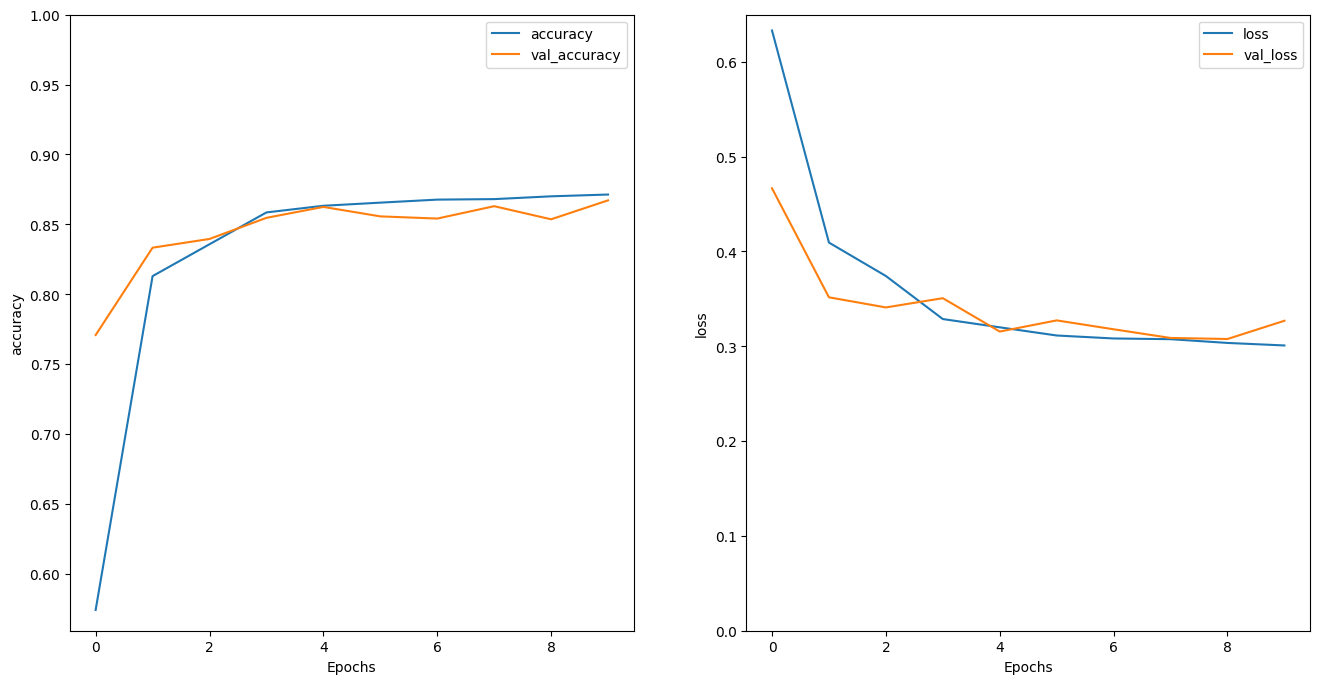

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [ ]:

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(tf.constant([sample_text]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


## Stack two or more LSTM layers

Lapisan berulang Keras memiliki dua mode yang tersedia yang dikontrol oleh argumen konstruktor return_sequences :

Jika False, ia hanya mengembalikan keluaran terakhir untuk setiap urutan masukan (bentuk tensor 2D (batch_size, output_features)). Ini adalah default yang digunakan pada model sebelumnya.

Jika True, Sequence lengkap output berturut-turut untuk setiap langkah waktu dikembalikan (bentuk tensor 3D (ukuran_batch, langkah waktu, fitur_output)).

Berikut adalah alur informasi dengan return_sequences=True:

Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                   validation_data=test_dataset,
                   validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - accuracy: 0.5128 - loss: 0.6801 - val_accuracy: 0.7891 - val_loss: 0.4953
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 47s 119ms/step - accuracy: 0.8053 - loss: 0.4361 - val_accuracy: 0.8438 - val_loss: 0.3438
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 116ms/step - accuracy: 0.8541 - loss: 0.3521 - val_accuracy: 0.8734 - val_loss: 0.3202
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 117ms/step - accuracy: 0.8653 - loss: 0.3272 - val_accuracy: 0.8516 - val_loss: 0.3308
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 113ms/step - accuracy: 0.8602 - loss: 0.3232 - val_accuracy: 0.8583 - val_loss: 0.3154
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 83s 115ms/step - accuracy: 0.8722 - loss: 0.3052 - val_accuracy: 0.8589 - val_loss: 0.3209
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 83s 117ms/step - accuracy: 0.8675 - loss: 0.3112 - val_accuracy: 0.8495 - val_loss: 0.3158
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 117ms/step - accuracy: 0.8737 - loss: 0

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.8621 - loss: 0.3287
Test Loss: 0.32664912939071655
Test Accuracy: 0.8621600270271301


In [ ]:
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(tf.constant([sample_text]))
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
[[-1.8989823]]


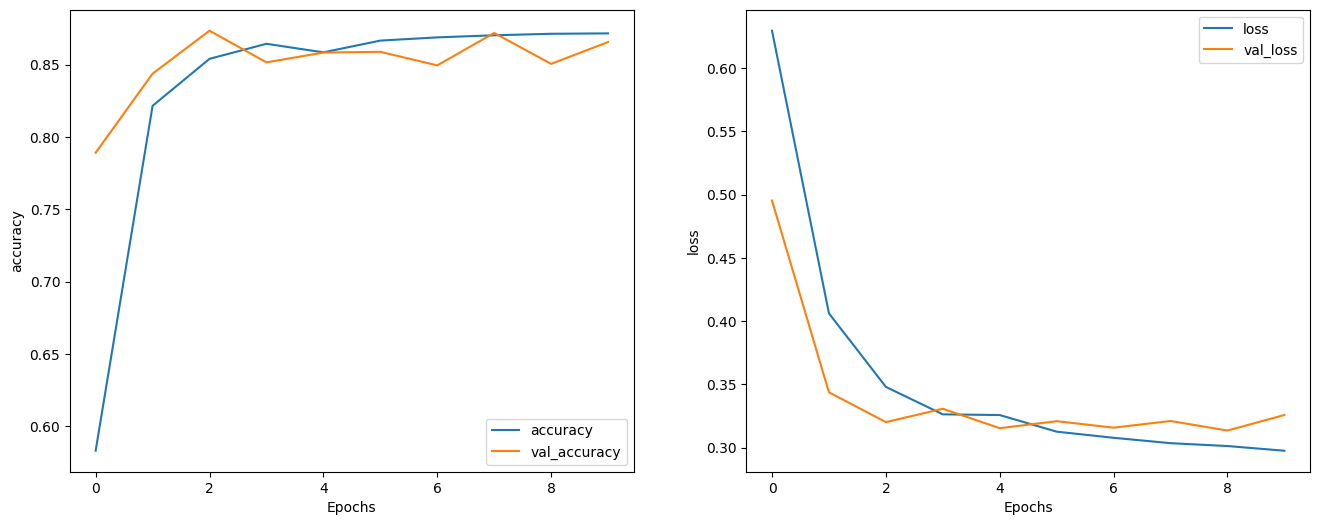

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Praktikum 2 Generator Teks dengan RNN

Praktikum ini mendemonstrasikan cara melakukan genearsi text menggunakan RNN. Dataset yang digunkan adalah dataset Shakespeare's writing from Andrej Karpathy's The Unreasonable Effectiveness of Recurrent Neural Networks. Jika diberikan urutan karakter dari data ini ("Shakespear"), latih model untuk memprediksi karakter berikutnya dalam urutan ("e"). Urutan teks yang lebih panjang dapat dihasilkan dengan memanggil model berulang kali.

Note: Enable GPU acceleration to execute this notebook faster. In Colab: Runtime > Change runtime type > Hardware accelerator > GPU.

Tutorial ini menggunakan tf.keras dan eager execution. Berikut adalah contoh output ketika model dalam tutorial ini dilatih selama 30 epoch, dan dimulai dengan prompt "Q":



LINK : https://www.tensorflow.org/text/tutorials/text_generation


In [1]:
import tensorflow as tf
import numpy as np
import os
import time

In [2]:
!pip install tf-keras

In [3]:
import tf_keras as keras

## Download Dataset Shakespeare
Sesuaikan dengan lokasi data yang Anda punya.

In [4]:
path_to_file=tf.keras.utils.get_file('shakespeare.txt','https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


## Load Data

In [5]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [6]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [7]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


## Olah Teks

Vectorize Teks

Sebelum training, Anda perlu mengonversi string menjadi representasi numerik. tf.keras.layers.StringLookup dapat mengubah setiap karakter menjadi ID numerik. Caranya adalah teks akan dipecah menjadi token terlebih dahulu.

In [8]:
example_texts=['abcdefg','xyz']
chars=tf.strings.unicode_split(example_texts,input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

sekarang buat tf.keras.layers.StringLookup layer:

In [9]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

perintah diatas mengconvert token menjadi id

In [10]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

Karena tujuan tutorial ini adalah untuk menghasilkan teks, penting juga untuk membalikkan representasi ini. Untuk ini Anda dapat menggunakan kode tf.keras.layers.StringLookup(..., invert=True).

Catatan: pada kode ini, daripada meneruskan kosakata asli yang dihasilkan dengan diurutkan(set(teks)) gunakan metode get_vocabulary() dari tf.keras.layers.StringLookup sehingga token [UNK] disetel dengan cara yang sama.

In [11]:

chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

Lapisan ini mengconvert kembali karakter dari vektor ID, dan mengembalikannya sebagai karakter tf.RaggedTensor:

In [12]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

Anda dapat menggunakan tf.strings.reduce_join untuk menggabungkan kembali karakter menjadi string.


In [13]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [14]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids),axis=-1)

## Prediksi
Diberikan sebuah karakter, atau serangkaian karakter, karakter apa yang paling mungkin berikutnya? Ini adalah tugas yang harus Anda latih agar model dapat melakukannya. Masukan ke model akan berupa urutan karakter, dan Anda melatih model untuk memprediksi keluaran berupa karakter berikut pada setiap langkah waktu. Karena RNN mempertahankan keadaan internal yang bergantung pada elemen yang terlihat sebelumnya, mengingat semua karakter dihitung hingga saat ini, karakter apa selanjutnya?

Membuat Trianing Set dan Target
Selanjutnya bagilah teks menjadi contoh sequence. Setiap masukan sequence akan berisi karakter seq_length dari teks. Untuk setiap masukan sequence, target prediksi berisi teks dengan panjang yang sama, hanya digeser satu karakter ke kanan. Jadi, bagi teks menjadi beberapa bagian seq_length+1. Misalnya, seq_length adalah 4 dan teks kita adalah "Hello". Urutan masukannya adalah "Hell", dan urutan targetnya adalah "ello". Untuk melakukan ini, pertama-tama gunakan fungsi tf.data.Dataset.from_tensor_slices untuk mengonversi vektor teks menjadi aliran indeks karakter.

In [15]:

all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [16]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [17]:

for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [18]:
seq_length = 100

Metode batch memungkinkan Anda dengan mudah mengonversi karakter individual ini menjadi urutan ukuran yang diinginkan.

In [19]:

sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


akan lebih mudah untuk melihat apa yang dilakukan jika Anda menggabungkan token kembali menjadi string:

In [20]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


Untuk pelatihan, Anda memerlukan kumpulan data pasangan (input, label). Dimana input dan label merupakan urutan. Pada setiap langkah waktu, inputnya adalah karakter saat ini dan labelnya adalah karakter berikutnya. Berikut adalah fungsi yang mengambil urutan sebagai masukan, menduplikasi, dan menggesernya untuk menyelaraskan masukan dan label untuk setiap langkah waktu:

In [21]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [22]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [23]:
dataset = sequences.map(split_input_target)

In [24]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


## Membuat Batch Training

Anda menggunakan tf.data untuk membagi teks menjadi sequence yang dapat diatur. Namun sebelum memasukkan data ini ke dalam model, Anda perlu mengacak data dan mengemasnya ke dalam batch.

In [25]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

## Buat Model

Bagian ini mendefinisikan model sebagai subkelas keras.Model (untuk lebih detilnya, lihat Making new Layers and Models via subclassing).

Model yang kita bangun memiliki 3 lapisan neural network :

tf.keras.layers.Embedding: Lapisan masukan. Tabel pencarian yang dapat dilatih yang akan memetakan setiap karakter-ID ke vektor dengan dimensi embedding_dim;

tf.keras.layers.GRU: lapisan RNN dengan ukuran unit=rnn_units (Anda juga dapat menggunakan lapisan LSTM di sini.)

tf.keras.layers.Dense: Lapisan keluaran, dengan keluaran vocab_size. Ini menghasilkan satu logit untuk setiap karakter dalam kosakata. Ini adalah log kemungkinan setiap karakter menurut model.

In [26]:

# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [27]:
class MyModel(keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [28]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

Untuk setiap karakter, model mencari penyematan, menjalankan GRU satu langkah waktu dengan penyematan sebagai masukan, dan menerapkan dense layer untuk menghasilkan log yang memprediksi kemungkinan log karakter berikutnya:

Note: Untuk pelatihan Anda bisa menggunakan model keras.Sequential di sini. Untuk menghasilkan teks nanti, Anda harus mengelola status internal RNN. Akan lebih mudah untuk memasukkan opsi input dan output status di awal, daripada mengatur ulang arsitektur model nanti. untuk detailnya bisa dilihat Keras RNN guide.

## Uji Model

Coba jalankan model dan cek apakah sudah sesuai dengan output

pertama, cek bentuk dari output

In [29]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [30]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Untuk mendapatkan prediksi aktual dari model, Anda perlu mengambil sampel dari distribusi keluaran, untuk mendapatkan indeks karakter aktual. Distribusi ini ditentukan oleh logit pada kosakata karakter. Catatan: Penting untuk mengambil sampel dari distribusi ini karena mengambil argmax dari distribusi tersebut dapat dengan mudah membuat model terjebak dalam infinote loop. Cobalah untuk contoh pertama di batch:

In [31]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

Hal ini memberi kita, pada setiap langkah waktu, prediksi indeks karakter berikutnya:

In [32]:
sampled_indices

array([49, 25, 31, 51, 37, 44, 47, 51, 49, 47, 37, 13, 41,  9,  3, 65, 16,
       35,  2, 51, 37, 14, 16, 20, 45, 11,  2, 15, 46, 30, 18, 62, 48, 55,
       48,  3, 27, 31, 37, 52, 44, 41, 15, 38, 54, 36, 27, 29, 12, 19, 58,
       14, 24, 11, 40, 54, 62, 39,  4, 35, 26, 58, 14, 19, 11, 17, 52, 18,
       62,  1, 65, 54, 53, 31, 19, 21, 65, 26, 60, 19, 22, 42, 43, 13, 17,
       14, 34, 16, 64, 49, 52, 12, 53, 57, 40,  7, 64,  9, 41, 64])

Dekode kode berikut untuk melihat teks yang diprediksi oleh model tidak terlatih ini:

In [33]:

print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'ICK:\nNor now my scandal, Richard, dost thou hear;\nFor thou shalt know this strong right hand of mine'

Next Char Predictions:
 b'jLRlXehljhX?b.!zCV lXACGf: BgQEwipi!NRXmebBYoWNP;FsAK:aowZ$VMsAF:DmEw\nzonRFHzMuFIcd?DAUCyjm;nra,y.by'


## Train Model
Pada titik ini permasalahan dapat dianggap sebagai permasalahan klasifikasi standar. Permasalahan dapat disimpulkan dengan : Berdasarkan status RNN sebelumnya, dan masukan langkah kali ini, prediksi kelas karakter berikutnya.

# Tambahan optimizer dan fungsi loss
loss function tf.keras.losses.sparse_categorical_crossentropy standar berfungsi dalam kasus ini karena diterapkan di seluruh dimensi terakhir prediksi. Karena model Anda mengembalikan logits, Anda perlu mengatur flag from_logits.

In [34]:
loss =tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [35]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1876965, shape=(), dtype=float32)


Model yang baru diinisialisasi tidak boleh terlalu yakin dengan dirinya sendiri, semua log keluaran harus memiliki besaran yang sama. Untuk mengonfirmasi hal ini, Anda dapat memeriksa bahwa eksponensial dari loss rata-rata harus kira-kira sama dengan ukuran kosakata. Loss yang jauh lebih tinggi berarti model tersebut yakin akan jawaban yang salah, dan memiliki inisialisasi yang buruk:


In [36]:
tf.exp(example_batch_mean_loss).numpy()

65.87088


Konfigurasikan prosedur pelatihan menggunakan metode tf.keras.Model.compile. Gunakan tf.keras.optimizers.Adam dengan argumen default dan fungsi loss.


In [37]:
model.compile(optimizer='adam',loss=loss)

Konfigurasi Checkpoints
Gunakan tf.keras.callbacks.ModelCheckpoint untuk memastikan bahwa checkpoint disimpan selama pelatihan:

In [38]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

## Lakukan Proses Training
Agar waktu pelatihan tidak terlalu lama, gunakan 10 epoch untuk melatih model. Di Colab, setel runtime ke GPU untuk pelatihan yang lebih cepat.



In [39]:
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 18s 54ms/step - loss: 2.7233
Epoch 2/20
172/172 [==============================] - 12s 54ms/step - loss: 1.9939
Epoch 3/20
172/172 [==============================] - 12s 55ms/step - loss: 1.7097
Epoch 4/20
172/172 [==============================] - 13s 58ms/step - loss: 1.5467
Epoch 5/20
172/172 [==============================] - 12s 60ms/step - loss: 1.4480
Epoch 6/20
172/172 [==============================] - 12s 62ms/step - loss: 1.3804
Epoch 7/20
172/172 [==============================] - 12s 61ms/step - loss: 1.3292
Epoch 8/20
172/172 [==============================] - 13s 63ms/step - loss: 1.2840
Epoch 9/20
172/172 [==============================] - 12s 62ms/step - loss: 1.2432
Epoch 10/20
172/172 [==============================] - 12s 61ms/step - loss: 1.2037
Epoch 11/20
172/172 [==============================] - 12s 62ms/step - loss: 1.1640
Epoch 12/20
172/172 [==============================] - 13s 62ms/step - loss: 1.1228
E

## Generate Teks

Cara termudah untuk menghasilkan teks dengan model ini adalah dengan menjalankannya dalam loop, dan menyimpan status internal model saat Anda menjalankannya.Setiap kali Anda memanggil model, Anda memasukkan beberapa teks dan state internal. Model mengembalikan prediksi untuk karakter berikutnya dan state barunya. Masukkan kembali prediksi dan state ke model untuk terus menghasilkan teks.

In [40]:
class OneStep(keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [41]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Jalankan secara berulang untuk menghasilkan beberapa teks. Melihat teks yang dihasilkan, Anda akan melihat model mengetahui kapan harus menggunakan huruf besar, membuat paragraf, dan meniru kosakata menulis seperti Shakespeare. Karena sedikitnya jumlah epoch pelatihan, model belum belajar membentuk kalimat runtut.

In [42]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
A goodly son! where is your business!

JOHN OF GAUNT:
Old Aside, make, Jumillo; bethink you;
You think he comes to like the traitor, in the duke dare,
Rest on the justice-cannot speak a wrong,
With death will have your bonnet, hang abused
This abul. Now, by my soul!

ANGELO:
You have indeed.

PARIS:
Patience is furrow; we are run and affairs
To whom the heepilverous of thy stepherd:
How stood upon my counsel and Grunt
Pauls' speed you not how I was marking by the field:
Sick her! not how my mitter crown;
And yet, another banish'd: if he could second
so loving joy in a second day or that Barnardine Henry's son away:
The duke is madamiles.

First Senator:
My poessy sweet;
Tran forth your maids, some humaner in his death,
Which was so much than a widow's death!
Too farewell, his solly defusion staining him.
Towards him I cannot, being better burn honesty:
I must be good to gaze upon this maid,
Made had envy in safety tilts,
And set the covert'st of force requital of yourselves.

PE

Hal termudah yang dapat Anda lakukan untuk meningkatkan hasil adalah dengan melatihnya lebih lama (coba EPOCHS = 30). Anda juga dapat bereksperimen dengan string awal yang berbeda, mencoba menambahkan lapisan RNN lain untuk meningkatkan akurasi model, atau menyesuaikan parameter suhu untuk menghasilkan prediksi yang kurang lebih acak.

Jika Anda ingin model menghasilkan teks lebih cepat, hal termudah yang dapat Anda lakukan adalah membuat teks secara batch. Pada contoh di bawah, model menghasilkan 5 keluaran dalam waktu yang hampir sama dengan waktu yang dibutuhkan untuk menghasilkan 1 keluaran di atas.

In [43]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nThat he could do that husband in this life,\nSince she do forbid thy bones.\n\nCAPULET:\nO my remembranch, bless my oath?\n\nNORTHUMBERLAND:\nWhen I saw her son, my true love is not speak.\nAnd, Warwick, now thus: thou art so quickly,\nTo flatter death over my sheep-shear'd cross;\nAnd for the serving-crown sound like sweet shepherd,\nCallishment beseech you, on mine honour,\nTo think it was sufficed to minister\nTo planch with Richmond, though prant shameful sun\nWere he the beht no least: if thou wedging on\nWe are but 'eard all us and the king's shame,\nTo honour on a tame of charge.\n\nCLARENCE:\nMeantime, sir.\n\nAUTOLYCUS:\nHow! would thy kingdom shall this groan next dead,\nTo help to that each and staul so many fly.\n\nKATHARINA:\nI'll not be enor.\n\nPROSPERO:\nTell A goodge of that name is meet you.\n\nPETRUCHIO:\nNot unlike, sir; the bearing bawer is all the rest\nTo high a dream that love to put him he\ncurred issue; that you not deep will I wave.\n\nE

## Ekspor Model Generator

Model satu langkah ini dapat dengan mudah disimpan dan digunakan kembali, memungkinkan Anda menggunakannya di mana pun tf.saved_model diterima.

In [44]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [45]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
Alix, being a bawd, so thought it good.

GRUMIO:
Nay, noble often are you so your will.

DUCHESS OF


# Tugas

Prosedur pelatihan pada praktikum 2 merupakan prosedur sederhana, yang tidak memberi Anda banyak kendali. Model ini menggunakan "teacher-forcing" yang mencegah prediksi buruk diumpankan kembali ke model, sehingga model tidak pernah belajar untuk pulih dari kesalahan. Jadi, setelah Anda melihat cara menjalankan model secara manual, selanjutnya Anda akan mengimplementasikan custom loop pelatihan. Hal ini memberikan titik awal jika, misalnya, Anda ingin menerapkan pembelajaran kurikulum untuk membantu menstabilkan keluaran open-loop model. Bagian terpenting dari loop pelatihan khusus adalah fungsi langkah pelatihan.

Gunakan tf.GradientTape untuk men track nilai gradient. Anda dapat mempelajari lebih lanjut tentang pendekatan ini dengan membaca eager execution guide.

Prosedurnya adalah "

Jalankan Model dan hitung loss dengan tf.GradientTape.

Hitung update dan terapkan pada model dengan optimizer

In [47]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

Kode diatas menerapkan train_step method sesuai dengan  Keras' train_step conventions. Ini opsional, tetapi memungkinkan Anda mengubah perilaku langkah pelatihan dan tetap menggunakan keras Model.compile and Model.fit methods.

In [48]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [49]:
model.compile(optimizer = keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [50]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 15s 63ms/step - loss: 2.7043


Atau jika ingin lebih mengetahui dalamnya, kita bisa membuat custom training loop sendiri:

In [51]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_state()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.1662
Epoch 1 Batch 50 Loss 2.0584
Epoch 1 Batch 100 Loss 1.9758
Epoch 1 Batch 150 Loss 1.8709

Epoch 1 Loss: 1.9838
Time taken for 1 epoch 13.42 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.7738
Epoch 2 Batch 50 Loss 1.7437
Epoch 2 Batch 100 Loss 1.6809
Epoch 2 Batch 150 Loss 1.6295

Epoch 2 Loss: 1.7022
Time taken for 1 epoch 12.97 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.6111
Epoch 3 Batch 50 Loss 1.5908
Epoch 3 Batch 100 Loss 1.5167
Epoch 3 Batch 150 Loss 1.5529

Epoch 3 Loss: 1.5410
Time taken for 1 epoch 12.63 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.5382
Epoch 4 Batch 50 Loss 1.4785
Epoch 4 Batch 100 Loss 1.4303
Epoch 4 Batch 150 Loss 1.4432

Epoch 4 Loss: 1.4439
Time taken for 1 epoch 12.19 sec
_____________________________________________________________________

Jalankan kode diatas dan sebutkan perbedaanya dengan praktikum 2?



Kode diatas menggunakan GradientTape untuk melatih model secara manual, berbeda dengan praktikum2 yang menggunakan metode fit() standar yang otomatis. Dengan GradientTape, pengguna memiliki kontrol penuh atas proses pelatihan, termasuk perhitungan loss, gradien, dan pembaruan parameter, memungkinkan modifikasi khusus pada setiap langkah. Pendekatan ini memungkinkan penerapan teknik lanjutan, seperti gradient clipping atau learning rate scheduling yang kompleks, yang sulit dicapai dengan fit(). Meskipun lebih kompleks, metode ini cocok untuk eksperimen tingkat tinggi atau kebutuhan penelitian yang memerlukan fleksibilitas tambahan, sementara fit() lebih sederhana dan ideal untuk eksperimen standar atau pemula.






